In [1]:
# Google colab setup.
import subprocess

def setup_google_colab_execution():
    subprocess.run(["git", "clone", "https://github.com/bookingcom/uplift-modeling-for-marketing-personalization-tutorial"]) 
    subprocess.run(["pip", "install", "-r", "uplift-modeling-for-marketing-personalization-tutorial/tutorial/requirements-colab.txt"]) 
    subprocess.run(["cp", "uplift-modeling-for-marketing-personalization-tutorial/tutorial/notebooks/utils.py", "./"])

running_on_google_colab = False # Set this to true if you're running this notebook on google colab

if running_on_google_colab:
    setup_google_colab_execution()

# Foundations Methods for Uplift Modeling

## 1. Introduction

### Overview
Conditional Average Treatment Effect (CATE) estimation is central to understanding how different individuals or groups respond to interventions. Estimating CATE helps organizations optimize budget constraints by directing resources where they will have the greatest impact.

### Key Concepts
1. **Uplift Modeling**: Predicts the incremental impact of a treatment on an individual. It is used in scenarios where the objective is to know which are the subgroups of the population that benefit from a treatment.
2. **Causal Inference**: Estimates the average effect of a treatment across a population, useful in policy-making. An example of an historical application to policy making is the work by David Card and Alan B. Krueger's on the impact of the minimum wage on employment (1993).
3. **Heterogeneous Treatment Effect (HTE) Estimation**: Focuses on understanding how treatment effects vary across subpopulations, allowing for personalized strategies.

CATE estimation is crucial for personalized interventions, helping businesses and organizations make better decisions in marketing, healthcare, and policy-making.

---

## 2. Uplift Modeling vs. Causal Inference vs. Heterogeneous Treatment Effect Estimation

### Conceptual Differences
- **Uplift Modeling**: Personalized predictions to identify individuals who will respond positively to an intervention (e.g., targeting "persuadable" customers in marketing).
- **Causal Inference**: Estimates the average treatment effect (ATE) across a population (e.g., evaluating public health measures).
- **HTE Estimation**: Explores how treatment effects differ across subgroups (e.g., understanding varying responses to a drug across demographics).

### Practical Example
Suppose a company runs a promotional campaign:
1. **Causal Inference**: "What is the average effect of the promotion on sales?"
2. **Uplift Modeling**: "Which customers will increase their purchases if they receive the promotion?"
3. **HTE Estimation**: "Which segments of customers are most likely to respond positively to the promotion?"

### Takeaway
All these techniques use interchangeably techniques to estimate CATE. The difference is in question they are trying to answer and in their historical origin, which is why they are referred to as different methods and use different terminology.


Below is a visualization showing how treatment effects differ in uplift modeling:

Failed to import duecredit due to No module named 'duecredit'


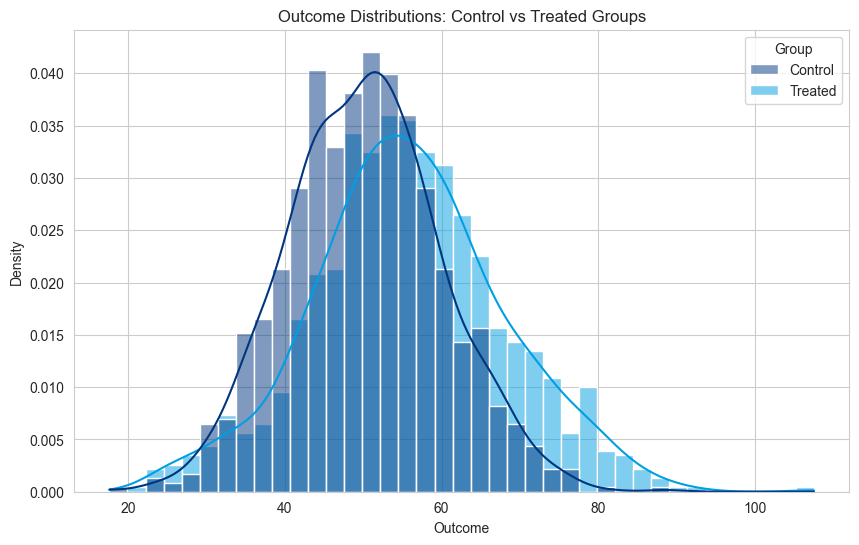

In [2]:
from causalml.dataset import synthetic_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
mpl.rcdefaults()
plt.style.use('default')
sns.set_style("whitegrid")
from utils import booking_colors
from cycler import cycler
plt.rc('axes', prop_cycle=cycler(color=list(booking_colors.values())))


# Generate synthetic data
np.random.seed(42)
n = 1000
control_group = np.random.normal(50, 10, n)
treated_group = control_group + np.random.normal(5, 8, n)

# Create a DataFrame for easier handling
df_plot = pd.DataFrame({
    'Outcome': np.concatenate([control_group, treated_group]),
    'Group': ['Control'] * n + ['Treated'] * n
})

# Plot the distribution of outcomes for both groups
plt.figure(figsize=(10, 6))
sns.histplot(df_plot, x='Outcome', hue='Group', kde=True, stat='density', common_norm=False)
plt.title('Outcome Distributions: Control vs Treated Groups')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

## 3. Data Generation with CausalML

To demonstrate these concepts practically, we will generate synthetic data using Python. The dataset simulates a randomized experiment, allowing us to evaluate different CATE estimation models.

As the data is generated from a synthetic simulation, it is possible to know the ground truth CATE value (something that is not possible in real-world data). This allows us to evaluate the estimation models' performance by comparing their CATE estimates with the ground truth. 

The **variable "tau" represents the ground truth CATE value**.

In [3]:
import pandas as pd
np.random.seed(42)

# Generate synthetic data
y, X, treatment, tau, b, e = synthetic_data(mode=2, n=5000, p=5, sigma=1.0)

# Convert data to a pandas DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['treatment'] = treatment
df['outcome'] = y
df['tau'] = tau  # True CATE

# Show sample data
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,treatment,outcome,tau
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,1,2.787963,1.123117
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,1,0.992414,1.532499
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,0,-0.588904,0.023736
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1,1.111354,-0.252461
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0,2.090639,2.052266


Train test split to evaluate the effectiveness of the estimators. The simulated data also contains ground truth which is usually not contained in real data. This allows to validate the quality of each model. 

In [4]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X = df.drop(columns=['outcome', 'tau'])
y = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Balanced datasets are key to ensuring that models generalize well. If certain subgroups are overrepresented or underrepresented, the model may become biased toward those groups, leading to inaccurate estimates.

## 4. Foundation Methods

For an overview of Metalearners, please refer to:
- Künzel, Sören R., et al. "Metalearners for estimating heterogeneous treatment effects using machine learning." Proceedings of the national academy of sciences 116.10 (2019): 4156-4165. [Link to paper](https://www.pnas.org/doi/full/10.1073/pnas.1804597116).

### S-Learner


#### Overview

The S-Learner uses a single model that takes both the features  $\mathbf{X}$  and the treatment indicator  T  as inputs. At training time, the S-learner just adds the treatment indicator as a feature. At inference time, the model is used to make two predictions (in the case of a single treatment and control groups), one with T=1 (for the treated) and another with T=0 (for the untreated) scenarios, and the difference in these predictions gives the estimated CATE.

#### Formula

For an individual with features  $\mathbf{X}$ , the CATE is estimated as:


$\hat{\tau}(\mathbf{X}) = f(\mathbf{X}, T=1) - f(\mathbf{X}, T=0)$


Where  $f(\mathbf{X}, T)$  is the predicted outcome from the model when  $T = 1$  (treated) or  $T = 0$  (untreated).

#### Code Implementation

In [5]:
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error


# Train S-Learner model
s_learner = LGBMRegressor()
s_learner.fit(X_train, y_train)

# Predict outcomes for treated and untreated scenarios
X_test_treated = X_test.copy()
X_test_treated['treatment'] = 1
X_test_untreated = X_test.copy()
X_test_untreated['treatment'] = 0

# Estimate CATE using the difference in predictions
cate_s_learner = s_learner.predict(X_test_treated) - s_learner.predict(X_test_untreated)

# Evaluate performance using Root Mean Squared Error
# This is only possible because we have simulated data with ground truth
rmse_score = root_mean_squared_error(df.loc[X_test.index, 'tau'], cate_s_learner)
print(f"S-Learner RMSE for CATE estimation: {rmse_score:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score 1.419537
S-Learner RMSE for CATE estimation: 0.3963


#### Visualization of S-Learner Predictions

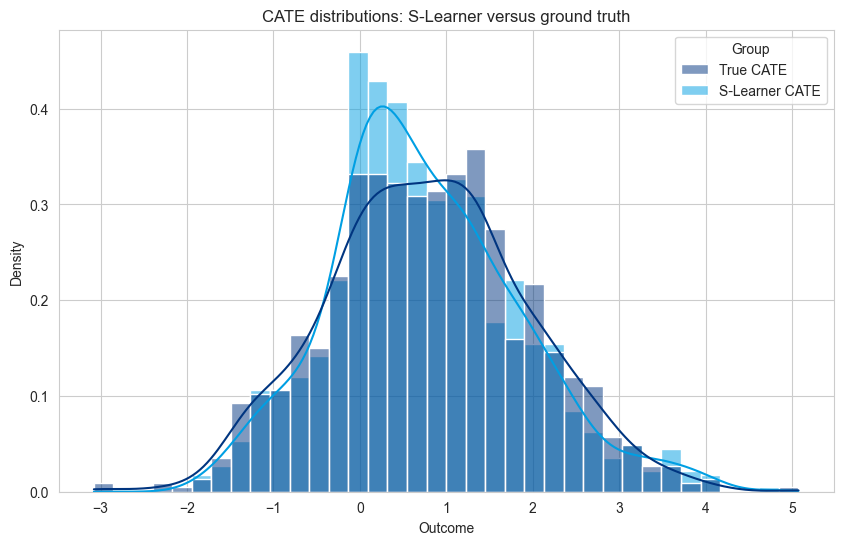

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


n = len(cate_s_learner)
# Create a DataFrame for easier handling
df_plot = pd.DataFrame({
    'Outcome': np.concatenate([df.loc[X_test.index, 'tau'].values, cate_s_learner]),
    'Group': ['True CATE'] * n + ['S-Learner CATE'] * n
})

# Plot the distribution of outcomes for both groups
plt.figure(figsize=(10, 6))
sns.histplot(df_plot, x='Outcome', hue='Group', kde=True, stat='density', common_norm=False)
plt.title('CATE distributions: S-Learner versus ground truth')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

####  Conclusions S-Learner

The S-learner is the simplest possible causal model, as it only uses one ML model without any changes to directly estimate the CATE. 

Advantages:
1. Simplicity - it is simple to use, train, mantain, and deploy. Your regular ML model.
2. Works well for sorting tasks - when the task only requires to sort decisions from better to worse ($\tau(\mathbf{X_1}) >  \tau(\mathbf{X_2})$) the bias estimate is less important.

Limitations:
1. Regularization - ML models implement regularization in order to not overfit. However, in the case of treatment effect estimation, this can bias the estimation to zero (as can be seen two figures above).
    1. Weak treatment effect - in some cases the feature importance for the treatment is smaller than for other features. This can lead, in some cases, in the removal of treatment as a feature from the model.
2. Different tasks - the S-learner is trying to estimate the outcome correctly, not exactly minimizing the error in the CATE estimation $Y(1) - Y(0)$. This can lead to more errors in the estimation. 

### T-Learner

#### Overview

The T-Learner trains two separate models: one for the treated group and one for the untreated group. The difference in predictions between these two models represents the CATE.

#### Formula

For an individual with features ( $\mathbf{X}$ ), the CATE is estimated as:

$\hat{\tau}(\mathbf{X}) = f_1(\mathbf{X}) - f_0(\mathbf{X})$

#### Code Implementation

In [7]:
# Split data into treated and untreated groups
treated = df[df['treatment'] == 1]
untreated = df[df['treatment'] == 0]

# Train separate models for treated and untreated groups
t_learner_treated = LGBMRegressor()
t_learner_treated.fit(treated.drop(columns=['outcome', 'tau', 'treatment']), treated['outcome'])

t_learner_untreated = LGBMRegressor()
t_learner_untreated.fit(untreated.drop(columns=['outcome', 'tau', 'treatment']), untreated['outcome'])

# Predict outcomes for both treated and untreated scenarios
cate_t_learner = (
    t_learner_treated.predict(X_test.drop(columns=['treatment'])) -
    t_learner_untreated.predict(X_test.drop(columns=['treatment']))
)

# Evaluate performance using Root Mean Squared Error
# This is only possible because we have simulated data with ground truth
rmse_score = root_mean_squared_error(df.loc[X_test.index, 'tau'], cate_t_learner)
print(f"T-Learner RMSE for CATE estimation: {rmse_score:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2492, number of used features: 5
[LightGBM] [Info] Start training from score 1.847935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2508, number of used features: 5
[LightGBM] [Info] Start training from score 0.959009
T-Learner RMSE for CATE estimation: 0.6287


#### Visualization of T-Learner Predictions

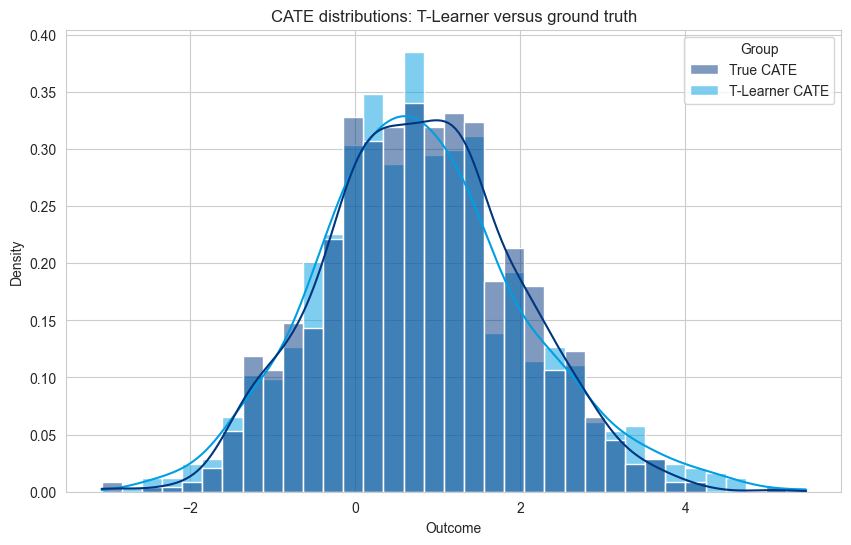

In [8]:
n = len(cate_t_learner)
# Create a DataFrame for easier handling
df_plot = pd.DataFrame({
    'Outcome': np.concatenate([df.loc[X_test.index, 'tau'].values, cate_t_learner]),
    'Group': ['True CATE'] * n + ['T-Learner CATE'] * n
})

# Plot the distribution of outcomes for both groups
plt.figure(figsize=(10, 6))
sns.histplot(df_plot, x='Outcome', hue='Group', kde=True, stat='density', common_norm=False)
plt.title('CATE distributions: T-Learner versus ground truth')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

####  Conclusions T-Learner

The T-learner is also quite simple, but can require multiple models (one per each treatment), that are trained independently.

Advantages:
1. Simplicity - it is simple and provides unbiased estimates.
2. Works well when data is abundant.

Limitations:
1. Not data efficient - each model is only trained on a subset of the data, thus, each model does not learn from the overall distribution of values.
2. Independent models - each model is trained independently, and thus subtracting the models' outputs may lead to incorrect treatment effects. This can arise from issues such as lack of calibration between models, some models being trained on smaller datasets (if one treatment has less data), thus to errors when the models' outcomes are aggregated.

### Outcome Transformation or Z-Learner

The Z-learner implements a simple outcome transformation that allows to estimate the CATE with a regular machine learning model.

The new outcome $Z$ is defined as a transformation of the outcome of interest $Y$, treatment $T$, and the propensity $e(x) = \Pr(T=1 | X)$ as follows: 

$\Large
Z= \left\{\begin{matrix}
\frac{Y}{e(x)} & \text{if  } \;T=1 \\
-\frac{Y}{1-e(x)} &  \text{if } \; T=0\\
\end{matrix}\right. 
$

It was shown that the outcome transformation converges to ATE over the whole data and to the CATE in a subset $\mathbf{X}$.
Thus, a model trained with covariates $X$ and outcome $Z$ is an estimator $\hat{\tau}(\mathbf{X})$ of the CATE.

#### Formula

For an individual with features ( $\mathbf{X}$ ), the CATE is estimated as:

$\hat{\tau}(\mathbf{X}) = f_Z(\mathbf{X})$

References:
- Gubela, Robin M., Stefan Lessmann, and Szymon Jaroszewicz. "Response transformation and profit decomposition for revenue uplift modeling." European Journal of Operational Research 283.2 (2020): 647-661. [Link to paper](https://arxiv.org/pdf/1911.08729).
- Rudaś, Krzysztof, and Szymon Jaroszewicz. "Linear regression for uplift modeling." Data Mining and Knowledge Discovery 32 (2018): 1275-1305. [Link to paper](https://link.springer.com/article/10.1007/s10618-018-0576-8).

#### Code Implementation

In [9]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# compute propensity 
propensity_treated = np.mean(X_train["treatment"].values)
print(f"Propensity score for the treatment group: {propensity_treated}")
propensity_treated_vector  = np.where(X_train["treatment"] == 1, propensity_treated, 1-propensity_treated)


# outcome transformation
treatment_train = X_train["treatment"].values
z_train = np.where(treatment_train == 1, y_train, -y_train)/propensity_treated_vector

# Train Z-Learner model
z_learner = LGBMRegressor()
X_train_without_treatment = X_train.copy().drop(columns=['treatment'])
z_learner.fit(X_train_without_treatment, z_train)

# Estimate CATE using the difference in predictions
X_test_without_treatment = X_test.copy().drop(columns=['treatment'])
cate_z_learner = z_learner.predict(X_test_without_treatment)

# Evaluate performance using AUC-ROC score
z_learner_rmse_score = root_mean_squared_error(df.loc[X_test.index, 'tau'], cate_z_learner)
print(f"Z-Learner RMSE for CATE estimation: {z_learner_rmse_score:.4f}")

Propensity score for the treatment group: 0.5005
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 5
[LightGBM] [Info] Start training from score 0.874679
Z-Learner RMSE for CATE estimation: 1.3314


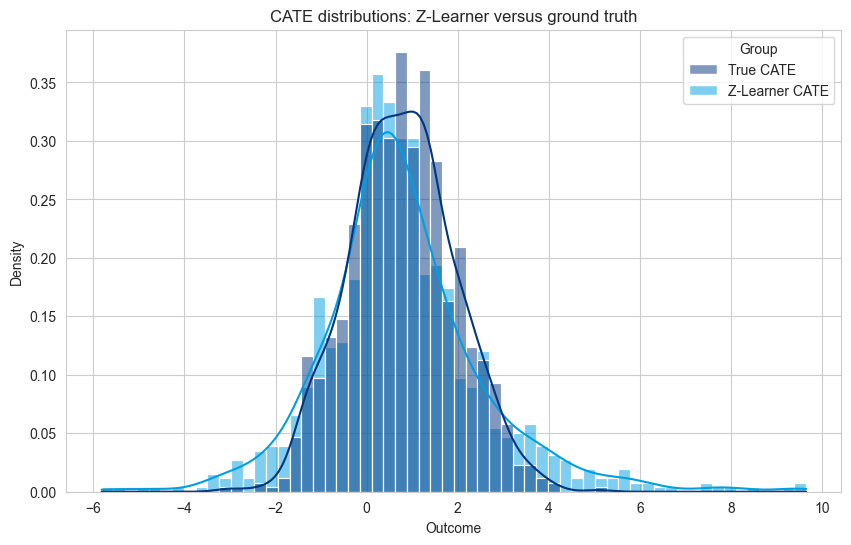

In [10]:
n = len(cate_t_learner)
# Create a DataFrame for easier handling
df_plot = pd.DataFrame({
    'Outcome': np.concatenate([df.loc[X_test.index, 'tau'].values, cate_z_learner]),
    'Group': ['True CATE'] * n + ['Z-Learner CATE'] * n
})

# Plot the distribution of outcomes for both groups
plt.figure(figsize=(10, 6))
sns.histplot(df_plot, x='Outcome', hue='Group', kde=True, stat='density', common_norm=False)
plt.title('CATE distributions: Z-Learner versus ground truth')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

####  Conclusions Z-Learner

The Z-learner is also quite simple; only requires one model for making CATE estimations, and only one model call to estimate it. This feature transformation is used under many guises in state-of-the-art loss functions to solve more complex problems.

Advantages:
1. Simplicity - it is a simple and unbiased estimator.
2. Works well when the treatment signal is small (the transformation with negative and positive amplifies the signal of the treatment).

Limitations:
1. Noisy and long tailed distributions - creating a distribution of negative and positive values, and calculating its mean, leads to a long tailed distribution and a not very elegant ML problem. This leads to predictions with a high-variance when compared to the true effect.


### Comparing All Models Side by Side

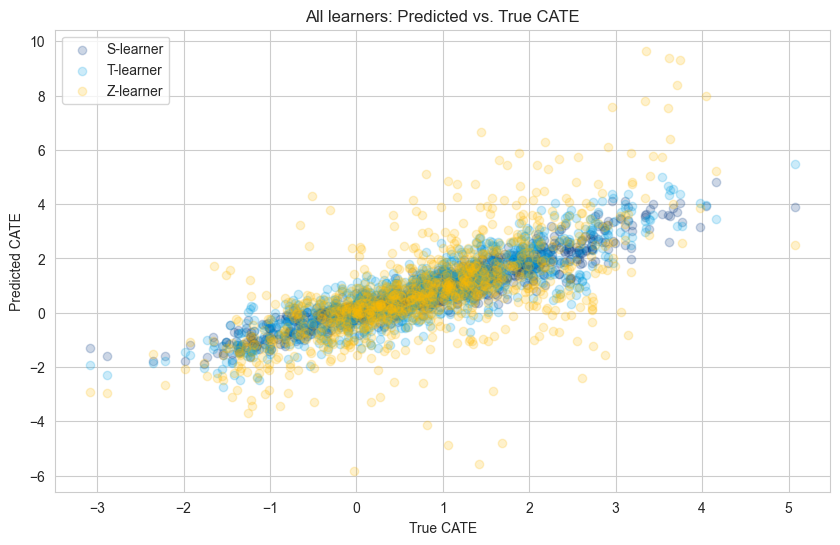

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(df.loc[X_test.index, 'tau'], cate_s_learner, alpha=0.2, label="S-learner")
plt.scatter(df.loc[X_test.index, 'tau'], cate_t_learner, alpha=0.2, label="T-learner")
plt.scatter(df.loc[X_test.index, 'tau'], cate_z_learner, alpha=0.2, label="Z-learner")
plt.title("All learners: Predicted vs. True CATE")
plt.xlabel("True CATE")
plt.ylabel("Predicted CATE")
plt.legend(loc="upper left")
plt.show()

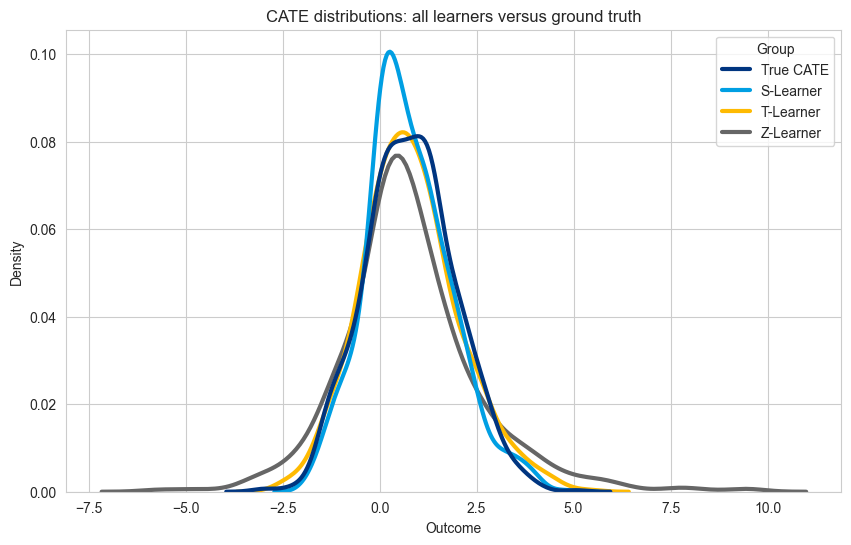

In [12]:
n = len(cate_t_learner)
# Create a DataFrame for easier handling
df_plot = pd.DataFrame({
    'Outcome': np.concatenate([df.loc[X_test.index, 'tau'].values, 
                               cate_s_learner,
                               cate_t_learner,
                               cate_z_learner,
                               ]
                              ),
    'Group': ['True CATE'] * n 
    + ['S-Learner'] * n
    + ['T-Learner'] * n
    + ['Z-Learner'] * n
})

# Plot the distribution of outcomes for both groups
plt.figure(figsize=(10, 6))
#sns.histplot(df_plot, x='Outcome', hue='Group', kde=True, stat='density', common_norm=False)
sns.kdeplot(df_plot, x='Outcome', hue='Group', linewidth=3)
plt.title('CATE distributions: all learners versus ground truth')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

The best model depends on the use case, but here follows some guidelines to take into consideration when selecting one of these learners.


#### Key Takeaways
- Bias in S-Learners: S-Learners struggle with small treatment effects; and the regularization can lead to biased predictions.
- Unbalanced Data in T-Learners: T-Learners prefer a balanced dataset; otherwise, the model trained on the smaller group may underfit, reducing performance. Also, models are trained independently which can lead to worse calibration problems (compared to using only one model).
- High variance in Z-learners: the outcome transformation leads to a harder machine learning problem, and consequently, to predictions with higher variance than the true-effect. Can be especially affected by outlier values.


### Other Meta-Learners and Tailored Methods

Over the years more complex models were proposed provide more accurate CATE estimates. 

Popular meta-learners include:
- X-Learner: An extension of the T-learner, it is often used when there is an imbalance in the number of treated vs. untreated samples. It constructs separate models for treatment and control groups and then uses those models to estimate treatment effects for each group. [Link to paper](https://arxiv.org/pdf/1706.03461).

- R-Learner: A flexible model for heterogeneous treatment effects estimation that first estimates nuisance parameters (like the propensity score and the outcome regression) and then applies a residual transformation to estimate treatment effects. [Link to paper](https://arxiv.org/pdf/1712.04912)


Popular tailored tree-based and neural network methods include:
- Uplift Trees and Uplift Forests: Models that estimate the Conditional Average Treatment Effect (CATE) by fitting decision trees that split based on the difference in treatment effects between the treated and untreated groups. [Link to paper](https://link.springer.com/article/10.1007/s10115-011-0434-0).
- Causal Forest: A generalization of random forests designed to estimate heterogeneous treatment effects by creating subgroups in the data that capture treatment effect variations. [Link to paper](https://doi.org/10.1214/18-AOS1709).
- Dragonnet: A deep neural network architecture that extends classical machine learning approaches by incorporating both outcome prediction and treatment assignment in a unified framework. It is designed to estimate treatment effects with an emphasis on balancing treated and untreated populations. [Link to paper](https://arxiv.org/pdf/1906.02120).


## 5. Evaluation of Uplift Models

### Introduction to Qini Curves

Qini curves are a key visualization tool for evaluating uplift models. Qini coefficient, which is the area under the Qini curve, is a metric that allows to compare models. Together, they help measure how effectively a model can target individuals who are most likely to be influenced by a treatment.

#### What Is a Qini Curve?

A Qini curve plots the cumulative incremental response (like profit or conversions) as a function of the proportion of the population targeted. In simple terms, it shows how much uplift (or gain) you achieve by targeting the top X% of individuals ranked by the uplift model.

#### How Qini Curves Work

- The x-axis represents the cumulative percentage of the population targeted.
- The y-axis represents the cumulative incremental response (e.g., additional revenue, profit, or conversions).

The area under the Qini curve (AUC) quantifies the model’s effectiveness: the higher the area, the better the model.

### Types of Qini Curves and Business Metrics

There are several types of Qini curves, depending on the business context:

- Conversion-Based Qini Curves: Evaluate how much the model improves conversion rates.
- Profit-Based Qini Curves: Focus on incremental profit.
- Multi-Treatment Qini Curves: Assess uplift across multiple treatments.


### References
Qini curves and Uplift curves can come in many flavours. For a good overview of the multiple possibilities we would refer to the Table 2 in the following work:
- Devriendt, Floris, et al. "Learning to rank for uplift modeling." IEEE Transactions on Knowledge and Data Engineering 34.10 (2020): 4888-4904. [Link to paper](https://arxiv.org/pdf/2002.05897).



### Implementation of Qini Curve for a Simple Uplift Model

In [13]:
def compute_cumulative_gain_one_treatment(
    prediction,
    outcome,
    treatment,
    propensity,
):
    """ Computes cumulative gain of a metric of interest when there is one treatment.
    
    It uses the outcome transformation of the Z-learner to cumulatively calculate the incremental effect.
    """
    
    sorted_descending_index_predictions = np.argsort(prediction)[::-1]
    transformed_score = np.where(treatment == 1, outcome, -outcome)/propensity

    transformed_score_by_highest_score = transformed_score[sorted_descending_index_predictions]
    
    # add noise in case predictions very similar
    very_small_gaussian_noise = np.random.normal(loc=0.0, scale=1e-16, size=len(prediction))
    transformed_score_by_highest_score = transformed_score_by_highest_score + very_small_gaussian_noise
    
    # forces sum to start at 0
    transformed_score_by_highest_score_zero_at_start = np.concatenate(([0],transformed_score_by_highest_score))
    
    cumulative_gain = np.cumsum(transformed_score_by_highest_score_zero_at_start)
    
    return cumulative_gain

### Random and Upper Bound

We can always compute two ideal curves:
- **Random** - if we would treat units at random, we would in effect be treating units with the Average Treatment Effect (ATE). Tracing a straight line between zero effect at 0% of population treated and the total effect at 100% of the population gives us the ideal random line.

- **Upper bound** - the upper bound is given if we could optimally separate every unit, in fact putting the treated units with highest positive outcome to the left, and the control units with the highest positive outcome to the right of the sorting. It is an unrealistic upper bound, but it is the theoretical limit for a given dataset.

Propensity score for the treatment group: 0.49


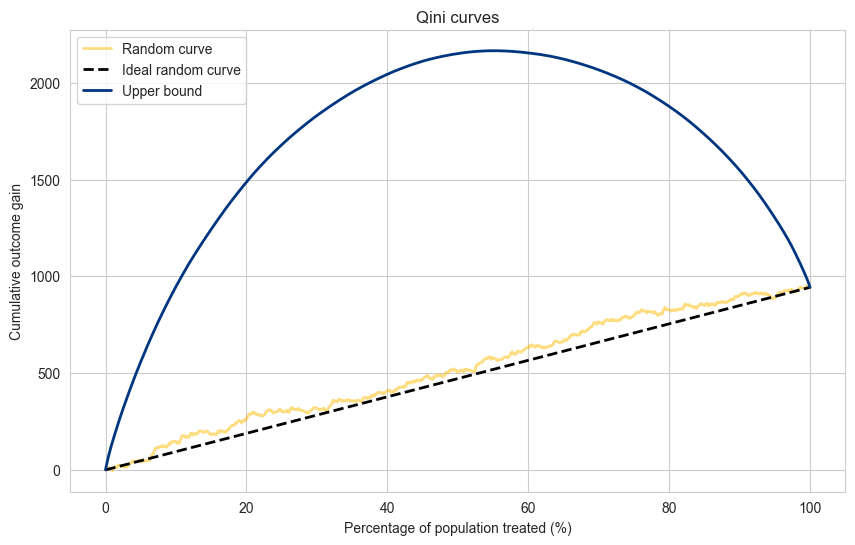

In [14]:
propensity_treated = np.mean(X_test["treatment"].values)
print(f"Propensity score for the treatment group: {propensity_treated}")
propensity_treated_vector  = np.where(X_test["treatment"] == 1, propensity_treated, 1-propensity_treated)
treatment_test = X_test["treatment"].values


# random prediction
predictions_random = np.random.uniform(size=len(y_test))
cumulative_gain_random = compute_cumulative_gain_one_treatment(
    prediction= predictions_random,
    outcome=y_test,
    treatment=treatment_test,
    propensity=propensity_treated_vector,
)

# random ideal line
transformed_score = np.where(treatment_test == 1, y_test, -y_test)/propensity_treated_vector
total_effect = np.sum(transformed_score)
cumulative_gain_ideal_random = np.linspace(0, total_effect, len(y_test)+1)


# Upper bound on performance
perfect_prediction = transformed_score
cumulative_gain_perfect_model = compute_cumulative_gain_one_treatment(
    prediction= perfect_prediction,
    outcome=y_test,
    treatment=treatment_test,
    propensity=propensity_treated_vector,
)


population_percentage = np.linspace(0, 100, len(y_test)+1)


# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_gain_random, label='Random curve', alpha=0.5, color=booking_colors['yellow'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_ideal_random, label='Ideal random curve',color='black',  linewidth=2.0, linestyle='dashed')
plt.plot(population_percentage, cumulative_gain_perfect_model, label='Upper bound', color=booking_colors['dark blue'], linewidth=2.0)

plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()

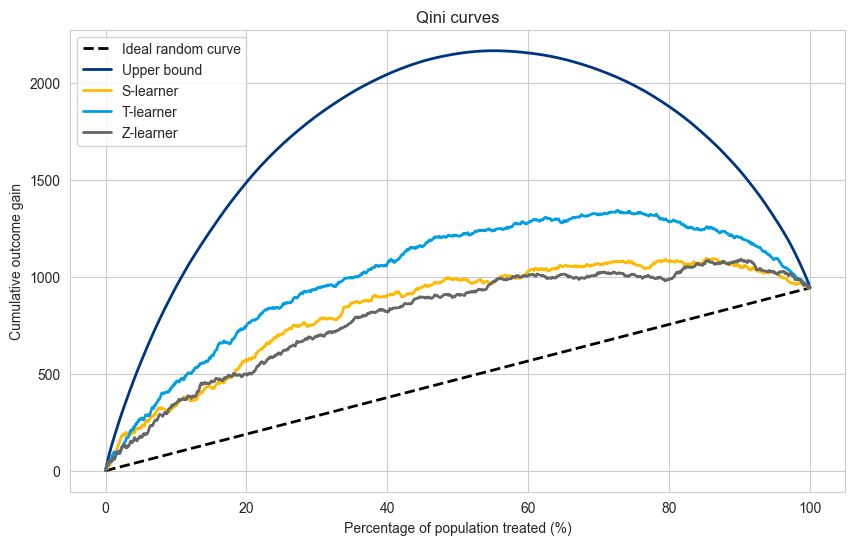

In [15]:
cumulative_gain_slearner = compute_cumulative_gain_one_treatment(
    prediction= cate_s_learner,
    outcome=y_test,
    treatment=treatment_test,
    propensity=propensity_treated_vector,
)

cumulative_gain_tlearner = compute_cumulative_gain_one_treatment(
    prediction= cate_t_learner,
    outcome=y_test,
    treatment=treatment_test,
    propensity=propensity_treated_vector,
)

cumulative_gain_zlearner = compute_cumulative_gain_one_treatment(
    prediction= cate_z_learner,
    outcome=y_test,
    treatment=treatment_test,
    propensity=propensity_treated_vector,
)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_gain_ideal_random, label='Ideal random curve',color='black',  linewidth=2.0, linestyle='dashed')
plt.plot(population_percentage, cumulative_gain_perfect_model, label='Upper bound', color=booking_colors['dark blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_slearner, label='S-learner', color=booking_colors['yellow'],  linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_tlearner, label='T-learner', color=booking_colors['light blue'],  linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_zlearner, label='Z-learner', color=booking_colors['dark grey'],  linewidth=2.0)


plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()

### Area Under the Qini Curve

As a measure of quality for each model one can compute the Area Under the Qini Curve (AUQC) to give one scalar value to compare all models accross all the percentages of population treated. Similar to how the Area Under the ROC (AUC) is used in regular prediction.

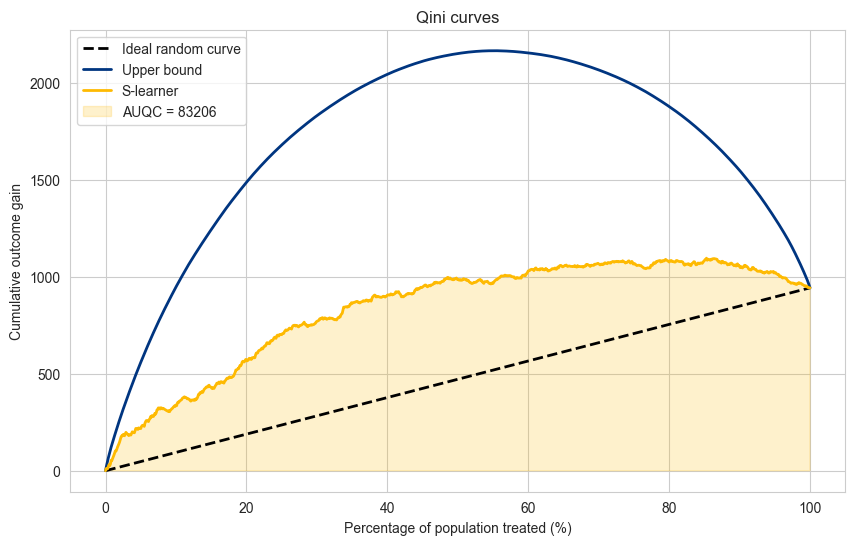

In [16]:
auqc_slearner = np.trapz(cumulative_gain_slearner,population_percentage)

zeros = np.zeros(len(population_percentage))

plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_gain_ideal_random, label='Ideal random curve',color='black',  linewidth=2.0, linestyle='dashed')
plt.plot(population_percentage, cumulative_gain_perfect_model, label='Upper bound', color=booking_colors['dark blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_slearner, label='S-learner', color=booking_colors['yellow'],  linewidth=2.0)

plt.fill(np.append(population_percentage, population_percentage[::-1]), 
         np.append(zeros, cumulative_gain_slearner[::-1]), 
         alpha=0.2, color=booking_colors['yellow'], label=f"AUQC = {auqc_slearner:.0f}"
         )
plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()

### Normalized Area Under the Qini Curve

The AUQC allows us to compare models in relation to a dataset, but does not allow to compare accross datasets.

For this case, we can use the normalized AUQC, which is comparison between the model AUQC, the random curve AUQC and the upper bound AUQC. In practical terms, it gives a score between 0 and 1, where zero represents a model that performs equal to random and 1 a model that performs equal to the upper bound. 

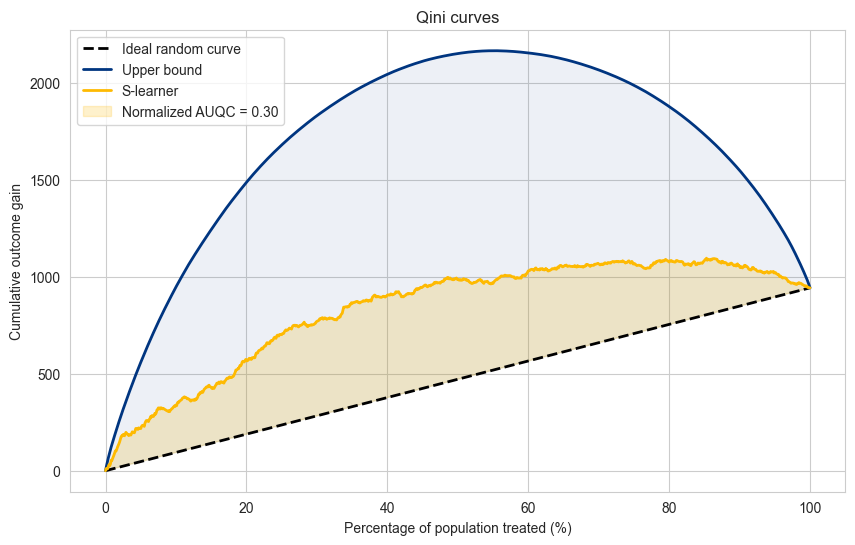

In [17]:
auqc_slearner = np.trapz(cumulative_gain_slearner,population_percentage)
auqc_random = np.trapz(cumulative_gain_ideal_random,population_percentage)
auqc_perfect = np.trapz(cumulative_gain_perfect_model,population_percentage)

normalized_auqc_slearner = (
    (auqc_slearner - auqc_random)/
    (auqc_perfect - auqc_random)
)
zeros = np.zeros(len(population_percentage))

plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_gain_ideal_random, label='Ideal random curve',color='black',  linewidth=2.0, linestyle='dashed')
plt.plot(population_percentage, cumulative_gain_perfect_model, label='Upper bound', color=booking_colors['dark blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_slearner, label='S-learner', color=booking_colors['yellow'],  linewidth=2.0)

plt.fill(np.append(population_percentage, population_percentage[::-1]), 
         np.append(cumulative_gain_ideal_random, cumulative_gain_slearner[::-1]), 
         alpha=0.2, color=booking_colors['yellow'], label=f"Normalized AUQC = {normalized_auqc_slearner:.2f}"
         )

plt.fill(np.append(population_percentage, population_percentage[::-1]), 
         np.append(cumulative_gain_ideal_random, cumulative_gain_perfect_model[::-1]), 
         alpha=0.07, color=booking_colors['dark blue'],
         )

plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()


#### Explanation

- The Qini curve is plotted based on the cumulative incremental gain as a function of the percentage of the population targeted.
- The diagonal dashed line represents a random model with no uplift effect.

#### Insights

- The higher the curve above the random line, the better the model is at identifying the right individuals to target.
- The area between the Qini curve and the random line is a useful metric to compare different models.

### One-Treatment vs. Multi-Treatment Settings

The evaluation strategies differ depending on whether you have a single treatment or multiple treatments.

- Single Treatment Qini Curves: In this case, you typically compare the control group (no treatment) with a single treatment group. The goal is to measure how much incremental gain the model achieves by correctly targeting individuals for this treatment.
- Multi-Treatment Qini Curves: In settings with multiple treatments (e.g., multiple types of promotions), you need to generate separate Qini curves for each treatment. Alternatively, you can create a combined Qini curve that measures overall performance across all treatments.

#### Example for Multi-Treatment Setting

We extend our Qini curve implementation to handle multiple treatments.

In [18]:
from causalml.dataset import make_uplift_classification
# Load multiple treatment dataset with conversion target
df, x_names = make_uplift_classification(n_samples=10000)

mapping_treatments_to_codes = {
    "control": 0,
    "treatment1": 1,
    "treatment2": 2,
    "treatment3": 3,
}
df.replace({"treatment_group_key": mapping_treatments_to_codes}, inplace=True)
df.rename(columns={"treatment_group_key": "treatment"}, inplace=True)

In [19]:
df.head()

,treatment,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,0,0.909486,0.828268,-0.016712,-0.872802,0.380530,0.273171,-0.020009,0.194151,1.387024,...,-1.957461,-0.775339,1.492639,-1.733130,-1.417696,-1.548022,-1.309032,-0.790066,1,0
1,2,-0.028409,-1.427630,1.813986,0.705597,1.148271,-1.996377,-0.801034,-1.699141,-0.139903,...,-0.622281,-0.962357,-1.283873,1.113277,0.640681,0.225083,-0.450529,0.150082,0,0
2,0,-0.132473,-1.772580,0.695160,-0.985407,-0.943285,1.040515,-1.382704,0.795706,-0.517023,...,-0.747040,-0.571946,-1.313160,1.295952,1.187784,-1.512765,-1.172256,-1.118350,0,0
3,2,-1.311725,-0.713705,-1.778944,0.155594,-0.580109,0.939822,0.425115,-1.223984,0.543634,...,-0.544115,0.482647,-0.082439,0.617260,0.591100,-2.180144,-1.524289,-1.991766,0,0
4,3,-1.381492,-0.529531,2.140560,0.306833,0.272251,-1.353378,1.837827,-0.536166,0.273723,...,-0.633821,-1.095470,-0.541334,0.905296,0.649222,2.346678,0.108862,1.196733,1,1


In [20]:
df.pivot_table(values='conversion',
               index='treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment,,
0,0.501200,10000
1,0.516000,10000
2,0.555400,10000
3,0.603500,10000
All,0.544025,40000


In [21]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
X_train = df_train.drop(['conversion', 'treatment_effect'], axis=1)
y_train = df_train['conversion']

X_test = df_test.drop(['conversion', 'treatment_effect'], axis=1)
y_test = df_test['conversion']
treatment_test = df_test['treatment'].values
treatment_effect_test = df_test['treatment_effect'].values

number_treatments = len(df["treatment"].unique())
treatments = sorted(df["treatment"].unique())

In [23]:
# Train S-Learner model
from lightgbm import LGBMClassifier
s_learner = LGBMClassifier()
s_learner.fit(X_train, y_train)

# control group data
X_test_untreated = X_test.copy()
X_test_untreated['treatment'] = 0

# Estimate CATE using the difference in predictions
cate_s_learner = np.zeros((X_test.shape[0], number_treatments))
for treatment in treatments:
    # add treatment group to data
    X_test_treated = X_test.copy()
    X_test_treated['treatment'] = treatment
    # probability of converted =1 
    cate_s_learner[:, treatment] = s_learner.predict_proba(X_test_treated)[:,1] - s_learner.predict_proba(X_test_untreated)[:,1]

# Evaluate performance using Root Mean Squared Error
number_test_rows = X_test.shape[0]
prediction_for_actual_treatment = cate_s_learner[np.arange(number_test_rows), treatment_test]
rmse_score = root_mean_squared_error(df.loc[X_test.index, 'treatment_effect'], prediction_for_actual_treatment)
print(f"S-Learner RMSE for CATE estimation: {rmse_score:.4f}")

[LightGBM] [Info] Number of positive: 17377, number of negative: 14623
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4849
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543031 -> initscore=0.172552
[LightGBM] [Info] Start training from score 0.172552
S-Learner RMSE for CATE estimation: 0.1239


### Multi-Treatment Qini Curve

The Qini curve for multiple treatments can be constructed based on four main insights:
1. Possible prescriptions - Multiple treatments can be prescribed for one instance.

2. Treatment selection - The treatment with the maximum treatment effect per instance is selected as the best treatment for that instance.

3. Only one ground truth treatment - There is only one ground truth treatment for each instance.

4. Discard instances - if the selected treatment and the ground truth treatment do not match, that instance is discarded as we cannot possibly measure the effect of that treatment in that instance.

Based on point 4. we need to create two types of matches:
1. Treatment match - find the instances where the ground truth treatment and selected treatment match.

2. Control match - find the instances where the ground truth treatment corresponds to the control group.

By cumulatively summing the matching values (and scaling them according to their propensity) we can make a cumulative curve of the selected treatment asignment according to a model.

In [24]:
def compute_cumulative_gain_multi_treatment(
    prediction,
    treatment_assignment,
    outcome,
    ground_truth_treatment,
    propensity,
    control_group = 0,
):
    """ This follows the idea of the z-transformation to calculate the treatment effect.

    In the case of 1 treatment and 1 control make the following transformation:
    transformed_outcome = + outcome/propensity if treatment != control_group 
                          - outcome/propensity if treatment == control_group

    This is an unbiased estimator of the mean performance. 

    In the case of multitreatment the idea is similar:

    transformed_outcome = + outcome/propensity if treatment != treatment_assignment
                          - outcome/propensity if treatment == control_group
                                             0 otherwise
                                             
    This assumes that we are using a randomized trial and if the instances are randomly distributed (according to their propesity), 
    then, on average the amount treatments assigments that are selected should be the same as those of the control group.

    An adjustment could be made in case that is not exactly true.
    """

    # if the ground truth treatment matches assigned treatment, make outcome positive, otherwise make it zero
    transformed_score_treatment_asignment = np.where(ground_truth_treatment == treatment_assignment, outcome, 0)/propensity
    
    # if the ground truth treatment matches control, make outcome negative, otherwise make it zero
    transformed_score_control_group = np.where(ground_truth_treatment == control_group, -outcome, 0)/propensity

    # total transformed outcome is the sum of both treatment assignments and control
    transformed_score = transformed_score_treatment_asignment + transformed_score_control_group
    
    # sort from the highest score to lowest
    very_small_gaussian_noise = np.random.normal(loc=0.0, scale=1e-16, size=len(prediction))
    sorted_descending_index_predictions = np.argsort(prediction+very_small_gaussian_noise)[::-1]
    transformed_score_by_highest_score = transformed_score[sorted_descending_index_predictions]
    
    # add the zero value at the start
    transformed_score_by_highest_score_zero_at_start = np.concatenate(([0],transformed_score_by_highest_score))
    
    # compute cumulative average
    cumulative_outcome_gain = np.cumsum(transformed_score_by_highest_score_zero_at_start)
    
    return cumulative_outcome_gain

In [25]:
# find propensity as the average (under a randomized controlled trial)
propensity_per_treatment = df_test["treatment"].value_counts(normalize=True).sort_index().values
propensity = propensity_per_treatment[treatment_test]

In [26]:
# S-learner
# for each instance the highest estimated effect gets selected
treatment_asignment = np.argmax(cate_s_learner, axis=1)
max_cate_prediction = np.max(cate_s_learner, axis=1)


cumulative_gain_slearner_multitreatment = compute_cumulative_gain_multi_treatment(
    prediction=max_cate_prediction,
    treatment_assignment=treatment_asignment,
    outcome=y_test,
    ground_truth_treatment=treatment_test,
    propensity=propensity,
    control_group = 0,
)

In [27]:
np.unique(treatment_asignment, return_counts=True)

(array([0, 1, 2, 3]), array([ 344,  598, 2743, 4315]))

In [28]:
sorted_ground_truth_treatment_effect = np.sort(treatment_effect_test)[::-1]/propensity 
sorted_ground_truth_treatment_effect = np.concatenate(([0],sorted_ground_truth_treatment_effect))
cumulative_ground_truth_gain = np.cumsum(sorted_ground_truth_treatment_effect)

In [29]:
random_effects = np.random.permutation(treatment_effect_test)/propensity
random_effects = np.concatenate(([0],random_effects))
cumulative_random = np.cumsum(random_effects)

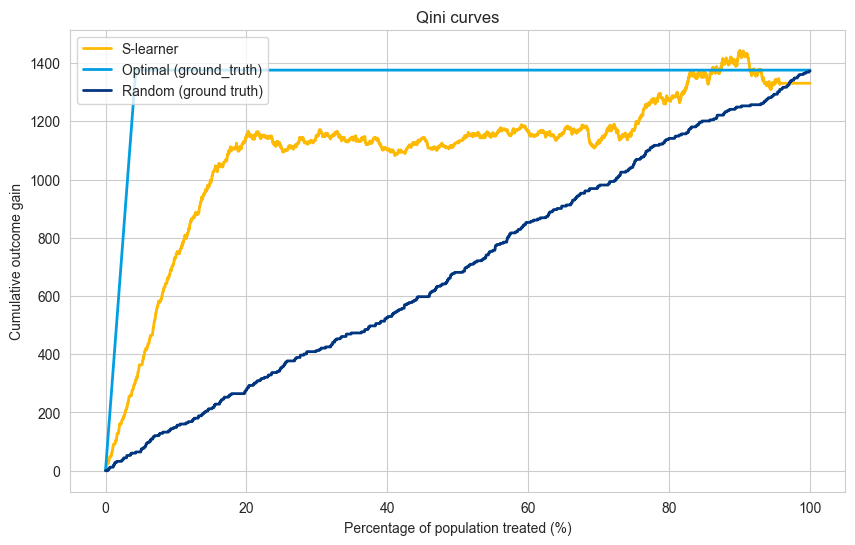

In [30]:
population_percentage = np.linspace(0, 100, len(y_test)+1)
auqc_slearner = np.trapz(cumulative_gain_slearner_multitreatment,population_percentage)
zeros = np.zeros(len(population_percentage))

plt.figure(figsize=(10, 6))

plt.plot(population_percentage, cumulative_gain_slearner_multitreatment, label='S-learner', color=booking_colors['yellow'], linewidth=2.0)
plt.plot(population_percentage, cumulative_ground_truth_gain , label='Optimal (ground_truth)', color=booking_colors['light blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_random , label='Random (ground truth)', color=booking_colors['dark blue'], linewidth=2.0)

plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()

**Note** : in the multi-treatment scenario the model curves (S-learner in this case) does not have to end up at the random or optimal line for 100% of the population treated because the matching is not perfect.

In [31]:
# random based on the s-learner
treatment_asignment = np.argmax(cate_s_learner, axis=1)
random_cate_prediction = np.random.rand(X_test.shape[0])

cumulative_gain_random = compute_cumulative_gain_multi_treatment(
    prediction=random_cate_prediction,
    treatment_assignment=treatment_asignment,
    outcome=y_test,
    ground_truth_treatment=treatment_test,
    propensity=propensity,
    control_group = 0,
)

In [32]:
# optimal based on the s-learner
treatment_asignment = np.argmax(cate_s_learner, axis=1)

# transform score based on ground truth
transformed_score = np.where(treatment_test == 0, -y_test, y_test)

cumulative_gain_optimal = compute_cumulative_gain_multi_treatment(
    prediction=transformed_score,
    treatment_assignment=treatment_asignment,
    outcome=y_test,
    ground_truth_treatment=treatment_test,
    propensity=propensity,
    control_group = 0,
)

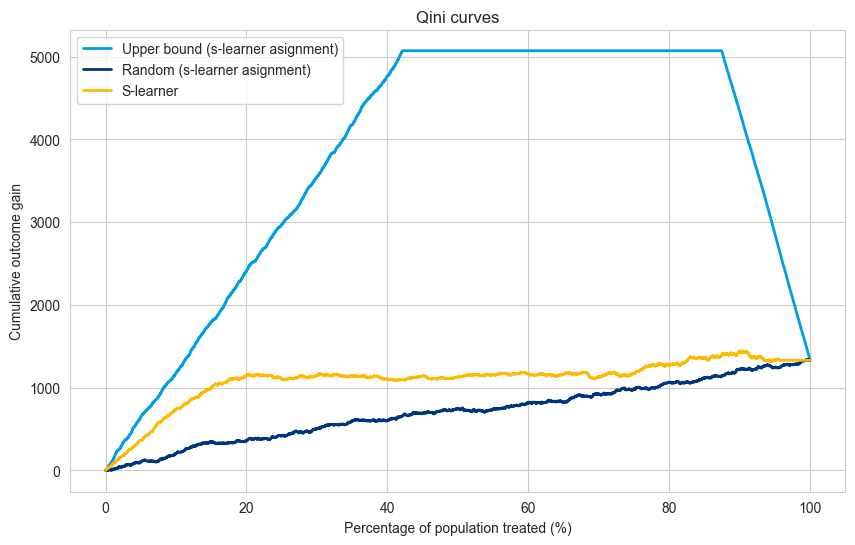

In [33]:
population_percentage = np.linspace(0, 100, len(y_test)+1)
auqc_slearner = np.trapz(cumulative_gain_slearner_multitreatment,population_percentage)
zeros = np.zeros(len(population_percentage))

plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_gain_optimal , label='Upper bound (s-learner asignment)', color=booking_colors['light blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_random, label='Random (s-learner asignment)', color=booking_colors['dark blue'], linewidth=2.0)
plt.plot(population_percentage, cumulative_gain_slearner_multitreatment, label='S-learner', color=booking_colors['yellow'], linewidth=2.0)

plt.title("Qini curves")
plt.xlabel("Percentage of population treated (%)")
plt.ylabel("Cumulative outcome gain")
plt.legend(loc="upper left")
plt.show()

#### Explanation

- The code now handles a scenario with multiple treatments (treatment A, treatment B, treatment C, and a control group).
- The Qini curve visualizes the overall performance of the model across all treatment groups.

#### Limitations

- Multi-level Qini curves require amounts of data proportional to the number of treatments (compared to one treatment Qini curve).
- The multi-level Qini is based on the idea that the amount of matches between selected treatment and ground truth is proportional to the propensity of that treatment. In case this assumption is violated (for some information leakage between covariates and treatment), the Qini curve can lead to wrong decisions.

### Conclusion

Qini curves provide an intuitive and powerful way to evaluate uplift models in both single-treatment and multi-treatment settings. The custom implementation provided here avoids reliance on specialized libraries, making it more flexible for experimentation.

You can use and adapt these Qini curve functions for evaluating different types of uplift models based on your specific use case and business metrics.